In [1]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
from pyprojroot import here

In [2]:
from osgeo.gdal_array import *

In [7]:
PET = gdal.Open(str(here("./data/intermediate/PET/PETbrick_OGres.tif")))

In [8]:
band = PET.GetRasterBand(1)
array = band.ReadAsArray()

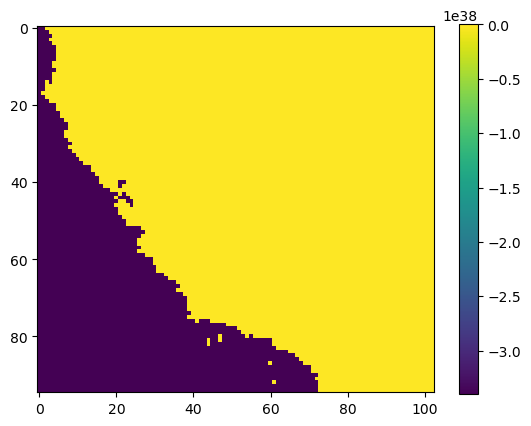

In [9]:
plt.figure()
plt.imshow(array)
plt.colorbar()
plt.show()

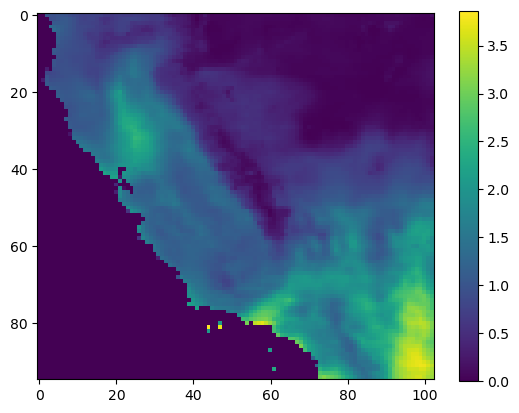

In [6]:
maskneg = np.where((array < 0), 0, array)
plt.figure()
plt.imshow(maskneg)
plt.colorbar()
plt.show()

In [16]:
CA_grid = gdal.Open(str(here("data/intermediate/CA_grid.tif")))

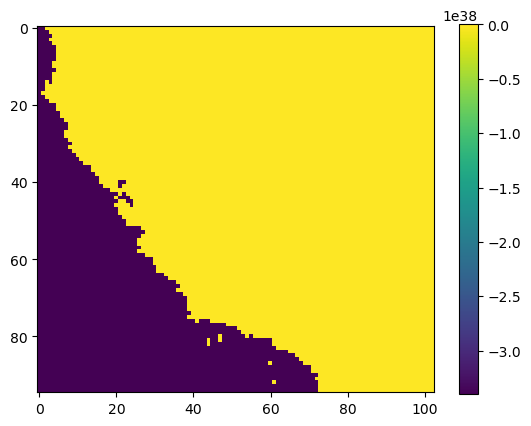

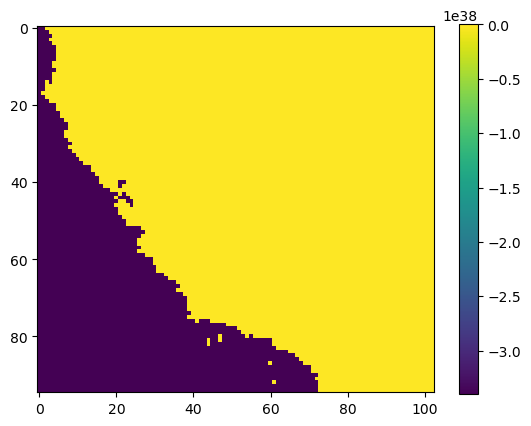

In [18]:
CA_grid_band = ds.GetRasterBand(1)
CA_grid_array = band.ReadAsArray()
plt.figure()
plt.imshow(CA_grid_array)
plt.colorbar()
plt.show()

In [23]:
CA_grid.GetProjection()

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

In [24]:
ulx, xres, xskew, uly, yskew, yres  = CA_grid.GetGeoTransform()

(-124.409740821737,
 0.0006309954707866042,
 0.0,
 42.0097687956553,
 0.0,
 -0.0006309954708085768)

In [25]:
PET.GetProjection()

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

In [26]:
PET.GetGeoTransform()

(-124.5,
 0.10097088860076608,
 0.0,
 42.099998474121094,
 0.0,
 -0.10105261551706414)

In [10]:
PET_resampled = gdal.Warp(str(here("data/intermediate/PET/PETbrick.tif")), 
                          xRes = xres, 
                          yRes = yres, 
                          resample_alg = 'near')

NameError: name 'xres' is not defined

In [11]:
# This script takes the bricked, resampled output of 6_PET.R and resamples it temporally to aggregate to necessary timesteps. 
# Anna Boser Nov 5, 2021

from pyprojroot import here
import rasterio
import datetime
import numpy as np
import pandas as pd

img = rasterio.open(here("./data/intermediate/PET/PETbrick_OGres.tif")) # NA values are -3.4e+38

# get a list of the start indices and end indices of each of your time intervals

# these are the dates of the images (bands) in order
base = datetime.date(day = 1, month = 1, year = 2019) # start Jan 1 2019
date_list = [base + datetime.timedelta(days=x) for x in range(img.count)]

# these are the start dates of the wanted time intervals
date_starts = [datetime.date(day = d, month = m, year = y) for y in (2019, 2020) for m in range(1, 13) for d in (1,15)]
del date_starts[5:9]
del date_starts[-3:-1]
del date_starts[-1]

# index of image on or nearest after start date
start_index = [date_list.index(min([i for i in date_list if i >= date_start], key=lambda x:x-date_start)) + 1 for date_start in date_starts] # plus one since bands are 1 indexed

# index of image on or nearest previous to start date + 61 days (this is for a non-inclusive index range so this date will be the first one not to be included in a subset)
end_index = [date_list.index(min([i for i in date_list if i <= date_start + datetime.timedelta(days=61)], key=lambda x:date_start+datetime.timedelta(days=61)-x)) + 1 for date_start in date_starts] # plus one since bands are 1 indexed

newarray = np.stack([array[start_index[i]:end_index[i]].mean(axis = 0) for i in range(0,len(start_index))], axis=0)

metadata = img.profile
metadata['count'] = 41

# write your new raster
with rasterio.open(here("./data/intermediate/PET/PET_rolling_avg_OGres.tif"), 'w', **metadata) as dst:
    dst.write(newarray)

/opt/anaconda3/envs/bplayground/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-11-8a821102c848>:30: RuntimeWarning: Mean of empty slice.
  newarray = np.stack([array[start_index[i]:end_index[i]].mean(axis = 0) for i in range(0,len(start_index))], axis=0)
/opt/anaconda3/envs/bplayground/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


ValueError: Source shape (41, 103) is inconsistent with given indexes 41

In [12]:
metadata

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 103, 'height': 95, 'count': 41, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.10097088860076608, 0.0, -124.5,
       0.0, -0.10105261551706414, 42.099998474121094), 'tiled': False, 'compress': 'lzw', 'interleave': 'pixel'}

In [13]:
img.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 103, 'height': 95, 'count': 731, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.10097088860076608, 0.0, -124.5,
       0.0, -0.10105261551706414, 42.099998474121094), 'tiled': False, 'compress': 'lzw', 'interleave': 'pixel'}

In [15]:
newarray.size

4223

In [16]:
newarray

array([[      -inf,       -inf,       -inf, ..., 0.6844871 , 0.67314446,
        0.6440895 ],
       [      -inf,       -inf,       -inf, ..., 1.2213075 , 1.1669371 ,
        1.0997866 ],
       [      -inf,       -inf,       -inf, ..., 2.1189315 , 2.0229335 ,
        1.9115535 ],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)